<a href="https://colab.research.google.com/github/Oleksij-gh/infotech-task/blob/main/infotech_test_task_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

to do:

исправить баг с y_val_

# 1. Libs

In [1]:
import copy
import pandas as pd
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import f1_score as f1

# 2. Loading Data

In [2]:
!gdown 1FYaj-YQn7WADkCflz8-4Q89G9Aj8XxOi

Downloading...
From: https://drive.google.com/uc?id=1FYaj-YQn7WADkCflz8-4Q89G9Aj8XxOi
To: /content/schedule_dataset.xlsx
100% 8.31M/8.31M [00:00<00:00, 17.1MB/s]


In [3]:
df = pd.read_excel('/content/schedule_dataset.xlsx')

In [4]:
df.head()

,Дата рейса,Рейс,А/П отправл,А/П прибыт,Номер ВС,Время отправления по расписанию,Время отправления фактическое,Время прибытия по расписанию,Время прибытия фактическое
0,2018-03-01,1,MOW,ARH,1,2018-03-01 00:05:00,2018-02-28 23:48:00,2018-03-01 02:00:00,2018-03-01 01:48:00
1,2018-03-01,2,MOW,EGO,2,2018-03-01 00:05:00,2018-03-01 00:00:00,2018-03-01 01:30:00,2018-03-01 01:55:00
2,2018-03-01,3,MOW,AKX,3,2018-03-01 00:15:00,2018-03-01 00:14:00,2018-03-01 02:40:00,2018-03-01 02:32:00
3,2018-03-01,4,LED,MOW,4,2018-03-01 00:20:00,2018-03-01 00:11:00,2018-03-01 01:35:00,2018-03-01 01:39:00
4,2018-03-01,5,MOW,KRR,5,2018-03-01 00:25:00,2018-03-01 00:21:00,2018-03-01 02:40:00,2018-03-01 02:41:00


# 3. Data preprocessing

In [5]:
df.columns

Index(['Дата рейса', 'Рейс', 'А/П отправл', 'А/П прибыт', 'Номер ВС',
       'Время отправления по расписанию', 'Время отправления фактическое',
       'Время прибытия по расписанию', 'Время прибытия фактическое'],
      dtype='object')

Переименуем столбцы

In [6]:
df  = df.rename(columns={'Дата рейса': 'flight_date',
                   'Рейс': 'flight',
                   'А/П отправл': 'airport_out',
                   'А/П прибыт': 'airport_in',
                   'Номер ВС': 'air_number',
                   'Время отправления по расписанию': 'scheduled_time_out',
                   'Время отправления фактическое': 'actual_time_out',
                   'Время прибытия по расписанию': 'scheduled_time_in',
                   'Время прибытия фактическое': 'actual_time_in'})

In [7]:
df.head()

,flight_date,flight,airport_out,airport_in,air_number,scheduled_time_out,actual_time_out,scheduled_time_in,actual_time_in
0,2018-03-01,1,MOW,ARH,1,2018-03-01 00:05:00,2018-02-28 23:48:00,2018-03-01 02:00:00,2018-03-01 01:48:00
1,2018-03-01,2,MOW,EGO,2,2018-03-01 00:05:00,2018-03-01 00:00:00,2018-03-01 01:30:00,2018-03-01 01:55:00
2,2018-03-01,3,MOW,AKX,3,2018-03-01 00:15:00,2018-03-01 00:14:00,2018-03-01 02:40:00,2018-03-01 02:32:00
3,2018-03-01,4,LED,MOW,4,2018-03-01 00:20:00,2018-03-01 00:11:00,2018-03-01 01:35:00,2018-03-01 01:39:00
4,2018-03-01,5,MOW,KRR,5,2018-03-01 00:25:00,2018-03-01 00:21:00,2018-03-01 02:40:00,2018-03-01 02:41:00


Проверка на пустые строки

In [8]:
df.isna().values.any()

False

In [12]:
df.isna().values.any()

True

In [13]:
df.shape

(139732, 10)

(60510, 15)

Извлечем день и месяц полёта в отдельные признаки

In [17]:
df['flight_month'] = df.apply(lambda x: x['flight_date'].month, axis=1)
df['flight_day'] = df.apply(lambda x: x['flight_date'].day, axis=1)
df['day_of_week'] = df.apply(lambda x: x['flight_date'].day_name(), axis=1)

Извлечем время взлёта\посадки в отдельный категориальный признак

In [18]:
df['time_part_out'] = df.apply(lambda x: (x['scheduled_time_out'].hour) // 3, axis=1)
df['time_part_in'] = df.apply(lambda x: (x['scheduled_time_in'].hour) // 3, axis=1)

Преобразование номера ВС к типу object, т.к. это категориальный признак и в дальнейшем будет преобразован с помощью endcoder

In [20]:
df['air_number'] = df['air_number'].astype(object)
df['time_part_out'] = df['time_part_out'].astype(object)
df['time_part_in'] = df['time_part_in'].astype(object)

In [21]:
df.head()

,flight_date,flight,airport_out,airport_in,air_number,scheduled_time_out,actual_time_out,scheduled_time_in,actual_time_in,delay_in,flight_month,flight_day,day_of_week,time_part_out,time_part_in
1,2018-03-01,2,MOW,EGO,2,2018-03-01 00:05:00,2018-03-01 00:00:00,2018-03-01 01:30:00,2018-03-01 01:55:00,1.0,3,1,Thursday,0,0
3,2018-03-01,4,LED,MOW,4,2018-03-01 00:20:00,2018-03-01 00:11:00,2018-03-01 01:35:00,2018-03-01 01:39:00,1.0,3,1,Thursday,0,0
4,2018-03-01,5,MOW,KRR,5,2018-03-01 00:25:00,2018-03-01 00:21:00,2018-03-01 02:40:00,2018-03-01 02:41:00,1.0,3,1,Thursday,0,0
6,2018-03-01,7,AMS,MOW,7,2018-03-01 00:35:00,2018-03-01 00:38:00,2018-03-01 03:50:00,2018-03-01 03:57:00,1.0,3,1,Thursday,0,1
9,2018-03-01,10,MOW,SVX,10,2018-03-01 00:45:00,2018-03-01 00:36:00,2018-03-01 03:05:00,2018-03-01 03:15:00,1.0,3,1,Thursday,0,1


In [ ]:
def get_delay_class(scheduled_time, actual_time, target='delay_in'):

  delay = (actual_time - scheduled_time ).total_seconds()

  if delay < 0:
    return np.nan
  elif delay == 0:
    return 0
  else:
    return 1

In [ ]:
df_in = df.copy()
df_out = df.copy()

In [ ]:
df_out['target'] = df_out.apply(lambda x: get_delay_class(x['scheduled_time_out'], x['actual_time_out']), axis=1)
df_in['target'] = df_in.apply(lambda x: get_delay_class(x['scheduled_time_in'], x['actual_time_in']), axis=1)

In [ ]:
df_in = df_in.dropna()
df_in = df_in.reset_index()
del df_in['index']
df_in.shape

In [ ]:
df_out = df_out.dropna()
df_out = df_out.reset_index()
del df_out['index']
df_out.shape

## In

## Out

# Формирование датасета

In [24]:
!pip install category_encoders --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 2.2 MB/s eta 0:00:00


In [25]:
target_column = 'target'
categorical_columns = ['airport_out', 'airport_in', 'air_number', 'day_of_week', 'time_part_out', 'time_part_in']

## One-hot-encoder

In [27]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
def get_endode(df):
  encoder = OneHotEncoder(sparse_output=False)
  ohe = encoder.fit_transform(df[categorical_columns])
  ohe_df = pd.DataFrame(ohe, columns=encoder.get_feature_names_out(categorical_columns))
  data = pd.concat([df[['flight_month', 'flight_day', 'flight']], ohe_df], axis=1)
  return data

In [28]:
encoder = OneHotEncoder(sparse_output=False)

In [29]:
ohe = encoder.fit_transform(df[categorical_columns])
ohe_df = pd.DataFrame(ohe, columns=encoder.get_feature_names_out(categorical_columns))

In [35]:
data = pd.concat([df[['flight_month', 'flight_day', 'flight']], ohe_df], axis=1)

## Catboost encoder

Кодируем категориальные признаки, выбран CatBoost Encoder, основываясь на сравнении в [бенчмарках](https://www.kaggle.com/code/subinium/11-categorical-encoders-and-benchmark)

In [22]:
from category_encoders.cat_boost import CatBoostEncoder

In [23]:
CBencoder = CatBoostEncoder()
cbe = CBencoder.fit_transform(df[categorical_columns], df[target_column])

In [22]:
data = pd.concat([cbe, df[['flight_month', 'flight_day', 'flight']]], axis=1)

NameError: name 'cbe' is not defined

## Train Test Val split

In [ ]:
def split_data(data, target)

In [37]:
X_train, X_test, y_train, y_test = train_test_split(data, df['target'], test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# 4. Models

## sklearn models

In [38]:
models = {}

# Logistic Regression
from sklearn.linear_model import LogisticRegression
models['Logistic Regression'] = LogisticRegression()

# Support Vector Machines
from sklearn.svm import LinearSVC
models['Support Vector Machines'] = LinearSVC()

# Decision Trees
from sklearn.tree import DecisionTreeClassifier
models['Decision Trees'] = DecisionTreeClassifier()

# Random Forest
from sklearn.ensemble import RandomForestClassifier
models['Random Forest'] = RandomForestClassifier()

# Naive Bayes
from sklearn.naive_bayes import GaussianNB
models['Naive Bayes'] = GaussianNB()

# K-Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier
models['K-Nearest Neighbor'] = KNeighborsClassifier()


In [39]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

accuracy, precision, recall, f1 = {}, {}, {}, {}
tn, fp, fn, tp = {}, {}, {}, {}

for key in models.keys():

    # Fit the classifier
    models[key].fit(X_train, y_train)

    # Make predictions
    predictions = models[key].predict(X_test)

    # Calculate metrics
    accuracy[key] = accuracy_score(predictions, y_test)
    precision[key] = precision_score(predictions, y_test)
    recall[key] = recall_score(predictions, y_test)
    f1[key] = f1_score(predictions, y_test)

    TN, FP, FN, TP = confusion_matrix(y_test, predictions).ravel()
    tn[key] = TN
    fp[key] = FP
    fn[key] = FN
    tp[key] = TP


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [41]:
df_model = pd.DataFrame(index=models.keys(), columns=['Accuracy', 'Precision', 'Recall'])
df_model['Accuracy'] = accuracy.values()
df_model['Precision'] = precision.values()
df_model['Recall'] = recall.values()
df_model['F1'] = f1.values()

df_model['TN'] = tn.values()
df_model['FP'] = fp.values()
df_model['FN'] = fn.values()
df_model['TP'] = tp.values()

df_model


,Accuracy,Precision,Recall,F1
Logistic Regression,0.926789,1.000000,0.926789,0.962004
Support Vector Machines,0.923814,0.996523,0.926783,0.960388
Decision Trees,0.867956,0.931170,0.926708,0.928934
Random Forest,0.925384,0.998306,0.926827,0.961240
Naive Bayes,0.385473,0.357792,0.944902,0.519045
K-Nearest Neighbor,0.922410,0.994918,0.926750,0.959625


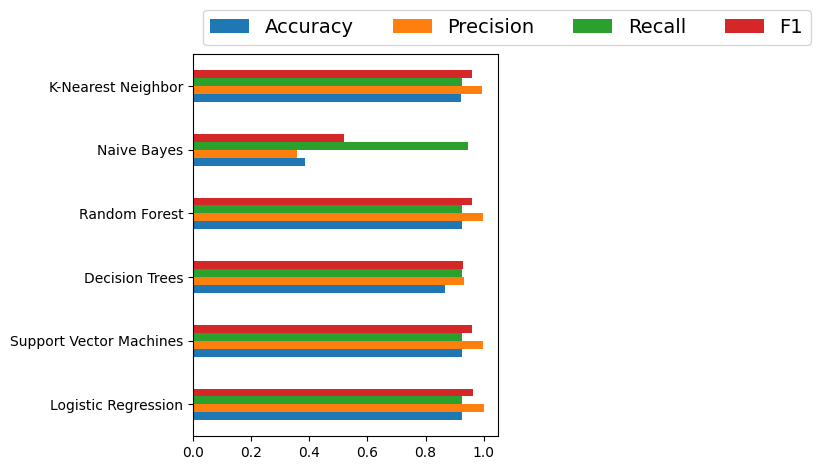

In [42]:
ax = df_model.plot.barh()
ax.legend(
    ncol=len(models.keys()),
    bbox_to_anchor=(0, 1),
    loc='lower left',
    prop={'size': 14}
)
plt.tight_layout()


## 4.3 PyTorch

In [43]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [44]:
X_train = torch.tensor(X_train.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32).reshape(-1, 1)
X_test = torch.tensor(X_test.values, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32).reshape(-1, 1)
X_val = torch.tensor(X_val.values, dtype=torch.float32)
y_val = torch.tensor(y_val.values, dtype=torch.float32).reshape(-1, 1)

### NN

In [45]:
X_train.shape

torch.Size([36306, 576])

In [46]:
import torch.nn as nn
import torch.nn.functional as F


class Model(nn.Module):

    def __init__(self):
        super(Model, self).__init__()

        self.fc1 = nn.Linear(576, 1024)
        self.fc2 = nn.Linear(1024, 2048)
        self.fc3 = nn.Linear(2048, 1024)
        self.fc4 = nn.Linear(1024, 512)
        self.dropout = nn.Dropout(p=0.1)
        self.fc5 = nn.Linear(512, 256)
        self.fc6 = nn.Linear(256, 1)
        #self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.dropout(x))
        x = F.relu(self.fc5(x))
        x = F.sigmoid(self.fc6(x))

        #return F.softmax(x, dim=1)
        return x


In [47]:
learning_rate = 1e-7

model = Model().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.BCELoss()

# training parameters
n_epochs = 5   # number of epochs to run
batch_size = 32  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)

# Hold the best model
best_loss = -np.inf   # init to infinity
best_weights = None
history = []


In [48]:
# training loop
for epoch in range(n_epochs):
    model.train()
    with tqdm(batch_start, unit="batch", mininterval=0, disable=False) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress

            bar.set_postfix(cross_val=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_val)
    loss = loss_fn(y_pred, y_val)
    history.append(loss)
    if loss < best_loss:
        best_loss = loss
        best_weights = copy.deepcopy(model.state_dict())

Epoch 4: 100%|██████████| 1135/1135 [02:18<00:00,  8.20batch/s, cross_val=0.381]


In [99]:
plt.plot(history)
plt.show()

AttributeError: 'list' object has no attribute 'detach'

In [49]:
y_test = y_test.detach().numpy()

In [50]:
pred = model(X_test).detach().numpy().round()
#y_test = y_test.detach().numpy()

# Score

In [107]:
from sklearn.metrics import confusion_matrix, f1_score

In [52]:
from sklearn.metrics import confusion_matrix
TN, FP, FN, TP = confusion_matrix(y_test, pred).ravel()
f1 = f1_score(y_test, pred)

print(f'F1 score = {f1}')
print(f'True Positive(TP)  = {TP}')
print(f'False Positive(FP) = {FP}')
print(f'True Negative(TN)  = {TN}')
print(f'False Negative(FN) = {FN}')


F1 score = 0.9620036023672699
True Positive(TP)  = 11216
False Positive(FP) = 886
True Negative(TN)  = 0
False Negative(FN) = 0


In [68]:
pred.round()

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)

# Chronos Time-series AMAZON

In [ ]:
!pip install git+https://github.com/amazon-science/chronos-forecasting.git --quiet

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

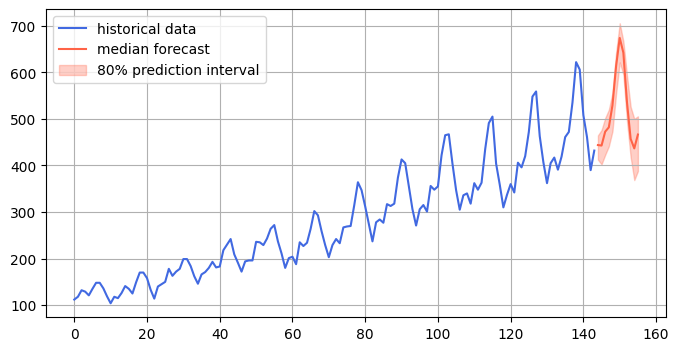

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from chronos import ChronosPipeline

pipeline = ChronosPipeline.from_pretrained(
  "amazon/chronos-t5-tiny",
  #device_map="cuda",
  torch_dtype=torch.bfloat16,
)

df = pd.read_csv("https://raw.githubusercontent.com/AileenNielsen/TimeSeriesAnalysisWithPython/master/data/AirPassengers.csv")

# context must be either a 1D tensor, a list of 1D tensors,
# or a left-padded 2D tensor with batch as the first dimension
context = torch.tensor(df["#Passengers"])
prediction_length = 12
forecast = pipeline.predict(context, prediction_length)  # shape [num_series, num_samples, prediction_length]

# visualize the forecast
forecast_index = range(len(df), len(df) + prediction_length)
low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)

plt.figure(figsize=(8, 4))
plt.plot(df["#Passengers"], color="royalblue", label="historical data")
plt.plot(forecast_index, median, color="tomato", label="median forecast")
plt.fill_between(forecast_index, low, high, color="tomato", alpha=0.3, label="80% prediction interval")
plt.legend()
plt.grid()
plt.show()

In [4]:
df.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
